TO DO hierarchial:
- Try dimensionality reduction before clustering
- Analyze sub clusters and look at their performance 
- Change metric when calculating clusters (currently ward) 
- Check with professor that euclidean makes sense because tf-idf is normalized   
- Scale up to multiple search terms. Figure out metrics to evaluate between. (silhouette etc.)
- Visualization with tsne or umap rather than mds

In [1]:
%reset -f

In [1]:
!pip install nltk
!pip install sklearn
!pip install gensim
!pip install matplotlib
!pip install networkx
!pip install kneed

In [2]:
import nltk
from nltk.corpus import reuters
import re
import numpy as np
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import sklearn
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster
import networkx as nx
import collections
import math
import operator
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
from kneed import KneeLocator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gimli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Data

In [3]:
# Extract fileids from the reuters corpus
fileids = reuters.fileids()

# Initialize empty lists to store categories and raw text
categories = []
text = []

# Loop through each file id and collect each files categories and raw text
for file in fileids:
    categories.append(reuters.categories(file))
    text.append(reuters.raw(file))

# Combine lists into pandas dataframe. reutersDf is the final dataframe. 
og = pd.DataFrame({'ids':fileids, 'categories':categories, 'text':text})

In [176]:
df = og.copy()

### Text Processing

In [177]:
# processing text
df.text = df.text.str.replace('\n', ' ')
df.text = df.text.str.replace('&lt;', '<')
df.text = df.text.str.replace("&amp;", "&")

# down case all
df.text = df.text.str.lower()

# remove symbols
df.text = df.text.str.replace('<', ' ')
df.text = df.text.str.replace('>', ' ')
df.text = df.text.str.replace('-', ' ')

# delete content specific "stop words"
delete_words = ['qtr', 'pct', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'bil', 'mln',
               'quarter', 'percent', 'million', 'billion', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 
                'august', 'september', 'october', 'november', 'december', 'janurary', 'said', 'year', 'month',
               'shr', 'cts', 'january\'s', 'february\'s', 'march\'s', 'april\'s', 'may\'s', 'june\'s', 'july\'s', 
                'august\'s', 'september\'s', 'october\'s', 'november\'s', 'december\'s']
for w in delete_words:
    df.text = df.text.str.replace(' ' + w + ' ', ' ')
    df.text = df.text.str.replace(' ' + w + '\\.', '.')

# remove punctuation
df.text = df.text.apply(lambda row: row.translate(str.maketrans('','',string.punctuation)))

# collapse words to acronyms so recognized as one concept/token (and currently they are mixed)
df.text = df.text.str.replace('united states', 'us')
df.text = df.text.str.replace('new zealand', 'nz')
df.text = df.text.str.replace('hong kong', 'hk')
df.text = df.text.str.replace('united kingdom', 'uk')
df.text = df.text.str.replace('dlrs', 'dollars')

# remove all numbers
    # originally removing number words
df.text = df.text.apply(lambda row: re.sub('\d*', '', row))

In [408]:
df_retail = df[df.categories.map(set(['trade']).issubset)] # subset to start with 
df_retail = df_retail.reset_index()

In [8]:
### done by tfidfvectorizer
# tokenize words
#df['tokens'] = df.text.apply(lambda row: nltk.word_tokenize(row))
# remove stopwords
#df.tokens = df.tokens.apply(lambda row: [w for w in row if not w in stopwords.words('english')])

# stemming? Maybe for clutering, but not for finding common words. 

## Tf-Idf Matrix

In [409]:
# tfidf. stop word removal. word tokenizer. 
tfidf = TfidfVectorizer(stop_words = 'english', analyzer = 'word')
m = tfidf.fit_transform(df_retail['text'])

# get words and scores in document 0
feature_names = tfidf.get_feature_names() # words 
#feature_index = m[0,:].nonzero()[1] # non zero words for first document
#tfidf_scores = zip(feature_index, [m[0, x] for x in feature_index]) # scores and words

#for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
#    print(w, s)
    
#tfidf.vocabulary_ 

In [410]:
dist = 1 - cosine_similarity(m)
# the diagonals are numbers very close to, but not quite zero (very small negative number)
# problematic for some functions that don't expect negative numbers
for i in range(len(dist)):
    dist[i][i] = 0
    
    
dist_e = euclidean_distances(m)  ## I think its ok to use euclidean because tf-idf normalizes
# euclidean can be innaccurate if documents are different lengths such that vectors are different lengths 
# I would prefer to use euclidean because then more sensicl to calculate centroids
# ask professor?? 

__Dimensionality Reduction__

In [182]:
pca = PCA(n_components = 0.8) # keep 95% of variance 
pcam = pca.fit_transform(m.toarray())

dist_e_pca = euclidean_distances(pcam)

### Hierarchial Clustering

In [183]:
# hieararchial clusters with children 
linkage_matrix = linkage(dist, method = 'ward') # try different methods
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
linkage_matrix_e = linkage(dist_e, method = 'ward') # try different methods

# dimensionality reduction
linkage_matrix_e_pca = linkage(dist_e_pca, method = 'ward') 


# plot dendogram
#fig, ax = plt.subplots(figsize=(15, 20))
#ax = dendrogram(linkage_matrix, orientation="right", labels = df_retail.ids.unique())

c:\users\gimli\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  
c:\users\gimli\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.
c:\users\gimli\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys


In [13]:
#score = dict()
#for k in range(2 , min(math.floor(len(df_retail) / 3), 10)): # want min(minimum avg 3 documents per cluster OR 10% docs)
#    f = fcluster(linkage_matrix, k, criterion = 'maxclust')
#    score[k] = sklearn.metrics.silhouette_score(m, f, metric = 'cosine')
    
# cluster number with max score
#k = np.argmax(score) + 2
#k = max(score.items(), key=operator.itemgetter(1))[0] + 2
#f = fcluster(linkage_matrix, k, criterion = 'maxclust')

## this seemingly doesn't calculate silhouette score right....

In [14]:
# https://stackoverflow.com/questions/21638130/tutorial-for-scipy-cluster-hierarchy
# idea for scree plot to determine number of clusters in fcluster using 'maxclust' in criterion

In [154]:
def frame_merge(df, f):
    # merge in with original data via pandas
    frameh = pd.DataFrame(df.index, index = [f], columns = ['index_retail'])
    frameh = pd.merge(frameh, df, right_index = True, left_on = 'index_retail')
    frameh['cluster'] = frameh.index.str[0]
    frameh = frameh.reset_index()
    return frameh

In [34]:
def centroid_label(frameh, m, feature_names):
    # most common words in clusters (based on tf-idf not just frequency)
    centroid = dict()
    labels = []
    for c in list(frameh.cluster.unique()):
        print()
        # most common words
        cluster1 = list(frameh[frameh.cluster == c].index.unique())
        # find documents cluster
        m1 = m[cluster1,:]
        # take mean vector among all documents
        m1 = m1.mean(axis = 0)
        # record mean vector: centroids of each sub cluster
        centroid[c] = m1

        # max values in mean vector 
        lst = []
        
        feature_names = tfidf.get_feature_names() # words 

        for i in np.argsort(np.asarray(m1)[0])[::-1][:6]:
            lst.append(feature_names[i])

        labels.append(lst)
        
    return labels, centroid

In [26]:
def silhouette_individ(frameh):
    sil_a = dict()
    for c in list(frameh.cluster.unique()):
        sil_a[c] = dict()
        docs_i = list(frameh[frameh.cluster == c].index.unique())
        for i in docs_i:
            lst = []
            for j in docs_i: 
                if i != j:
                    lst.append(np.linalg.norm(m[i].toarray()-m[j].toarray()))
            sil_a[c][i] = np.mean(lst)

    sil_b = dict()
    for c in list(frameh.cluster.unique()):
        sil_b[c] = dict()
        docs_in = list(frameh[frameh.cluster == c].index.unique())
        docs_out = list(frameh[frameh.cluster != c].index.unique())
        for i in docs_in:
            lst = []
            for j in docs_out: 
                lst.append(np.linalg.norm(m[i].toarray()-m[j].toarray()))
            sil_b[c][i] = np.mean(lst)
            
    return sil_a, sil_b

In [27]:
def silhouette_take_avg(sil):
    avg = []
    for v in sil.values():
        avg.append(list(v.values()))
    avg = [item for sublist in avg for item in sublist]
    avg = [0 if math.isnan(i) else i for i in avg]
    avg = np.mean(avg)
    
    return avg

In [28]:
def silhouette_avg(frameh):
    sil_a, sil_b = silhouette_individ(frameh)
    avga = silhouette_take_avg(sil_a)
    avgb = silhouette_take_avg(sil_b)

    return (avgb - avga) / max(avgb, avga)

distortion is only within cluster but is good because can measure rate of change  
silhouette captures within and without cluster

In [155]:
# distortion - sum of squared errors between points and its centroid 
# barely varies with different cluster numbers
distortion = dict()
silhouette = dict()

# min # clusters: want maximum 25 documents per cluster 
#if len(df_retail) / 3 > 10:
#    min_k = 3 
#else:
#    min_k = 2
    
for k in range(2, min(math.floor(len(df_retail) / 3), 10)): 
    # max # clusters: 1/3 of documents as long as get on average 10 docs per. Else limit to 1/2 of documents. 
    # min # clusters: 2 
    f = fcluster(linkage_matrix_e_pca, k, criterion = 'maxclust') ## using euclidean distance 
    frameh = frame_merge(df_retail, f)
    labels, centroid = centroid_label(frameh, pcam, feature_names)
    
    # calculate silhouette 
    silhouette[k] = silhouette_avg(frameh)

    # calculate distortion
    sumd = 0
    for i in list(frameh.index.unique()):
        c = int(frameh[frameh.index == i].cluster)
        sumd += np.linalg.norm(pcam[i]-centroid[c])
        
    # take average 
    distortion[k] = sumd

In [156]:
silhouette # mehhhh just increases as number of clusters increases
# maybe use for evaluation between topics rather than for selection 

{2: 0.031271387796475786,
 3: 0.051665074490107286,
 4: 0.0691993987455559,
 5: 0.08394077978113301,
 6: 0.09511438668496348,
 7: 0.1066372518970898}

In [157]:
# relative rate of change 
roc = []
for k,v in distortion.items(): 
    if k+1 in distortion:
        roc.append(abs(distortion[k+1] - distortion[k]) / distortion[k])

In [82]:
# find k 
#for i in range(len(roc)):
#    if i == 0:
#        continue
#    print(i)
#    print(abs(roc[i] - roc[i-1]))
#    if abs(roc[i] - roc[i-1]) >  .005: # threshold in change of roc -- this threshold might be too tight? 
                                        # tried roc threshold, but magnitude changes for different topics 
#        k = i+1 # number of clusters
#        break

1
0.008796509638786944


In [158]:
# find k using knee method 
from kneed import KneeLocator
kn = KneeLocator(range(len(roc)), roc, curve='convex', direction='decreasing')
k = kn.knee + 1 # index started at 0 

In [160]:
k

2

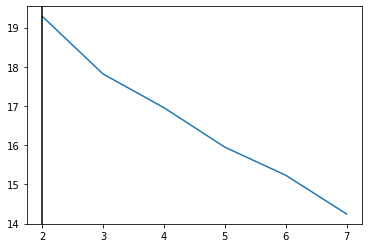

In [161]:
# plot distortion
fig, ax = plt.subplots()

distortion = sorted(distortion.items()) # sorted by key, return a list of tuples
x, y = zip(*distortion) # unpack a list of pairs into two tuples
ax.plot(x,y)
ax.axvline(k, color = 'black')


In [163]:
# use this number of clusters to form final clusters
f = fcluster(linkage_matrix, k, criterion = 'maxclust')
frameh = frame_merge(df_retail, f)
labels, centroid = centroid_label(frameh, m, feature_names)

In [164]:
labels

[['sales', 'retail', 'inary', 'rose', 'fall', 'ion'],
 ['rose', 'inary', 'orders', 'goods', 'inuary', 'turnover']]

__Find Documents at Each Level of Hierarchy__

In [26]:
# in linkage matrix, indicate the aggregated node for each node pair
links = pd.DataFrame(linkage_matrix_e) # using euclidean 
links.columns = ['source1', 'source2', 'd', 'n']

links['target'] = 0
n = 24 
for i, row in links.iterrows():
    n += 1
    links.at[i,'target'] = n

In [27]:
# flatten irregular nested lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

In [28]:
def merge_docs(merge, source):
    merge = pd.merge(merge, merge[['target', 'docs']], left_on = source, right_on = 'target',  how = 'left')
    merge.docs_x = np.where(merge.docs_x.isnull(), '', merge.docs_x)
    merge.docs_y = np.where(merge.docs_y.isnull(), '', merge.docs_y)
    merge['docs'] = merge[['docs_x', 'docs_y']].values.tolist()
    merge = merge.drop(columns = ['docs_x', 'docs_y'])
    #merge.docs = merge.docs.apply(np.ravel)
    merge = merge.rename(columns = {'target_x':'target'})
    merge.docs = list(merge.docs.apply(lambda row: flatten(row)))
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])

    return merge

In [29]:
# initial merge between frame ids and source1/source2
merge = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
merge = pd.merge(merge, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
# create single docs list column 
merge = merge.rename(columns = {'ids_x':'docs1', 'ids_y':'docs2'})
merge.docs2 = np.where(merge.docs2.isnull(), '', merge.docs2)
merge.docs1 = np.where(merge.docs1.isnull(), '', merge.docs1)
merge['docs']= merge[['docs1', 'docs2']].values.tolist()
merge = merge.drop(columns = ['docs1', 'docs2'])
# flattern docs list column
merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])
merge['len'] = merge.docs.apply(lambda row: len(set(row)))

merge1 = merge.copy()

# loop until have one id per document at node (n)
while int(merge[merge.target == merge.target.max()].len) != int(merge[merge.target == merge.target.max()].n): 
    merge = merge_docs(merge, 'source1')
    merge = merge_docs(merge, 'source2')
    merge['len'] = merge.docs.apply(lambda row: len(set(row)))
    
merge.docs = merge.docs.apply(lambda row: set(row))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\gimli\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-36f3cc872e88>", line 19, in <module>
    merge = merge_docs(merge, 'source2')
  File "<ipython-input-28-39ced3f4dd0d>", line 10, in merge_docs
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])
  File "c:\users\gimli\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\series.py", line 3194, in apply
    mapped = lib.map_infer(values, f, convert=convert_dtype)
  File "pandas/_libs/src\inference.pyx", line 1472, in pandas._libs.lib.map_infer
  File "<ipython-input-28-39ced3f4dd0d>", line 10, in <lambda>
    merge.docs = merge.docs.apply(lambda row: [i for i in row if i != ''])
  File "<ipython-input-28-39ced3f4dd0d>", line 10, in <listcomp>
    merge.docs = merge.docs.apply(lambda row: [i for 

KeyboardInterrupt: 

In [ ]:
# create graph reflecting hierarchy
G = nx.DiGraph()
G.add_nodes_from(links.source1)
G.add_nodes_from(links.source2)
G.add_nodes_from(links.target)

subset = links[['source1', 'target']]
G.add_edges_from([tuple(x) for x in subset.values])
subset = links[['source2', 'target']]
G.add_edges_from([tuple(x) for x in subset.values])

In [ ]:
# add docs to each target node so know which docs exist at each target 
for i in list(merge.target.unique()):
    G.nodes[i]['docs'] = merge[merge.target == i].docs.values[0]
    
# add docs to origianl nodes as well 
ogdocs = pd.merge(links, frameh[['ids']], left_on = 'source1', right_index = True, how = 'left')
ogdocs = pd.merge(ogdocs, frameh[['ids']], left_on = 'source2', right_index = True, how = 'left')
for i in range(25):
    if len(ogdocs[ogdocs.source1 == i].ids_x) != 0:
        G.nodes[i]['docs'] = ogdocs[ogdocs.source1 == i].ids_x.values[0]
    if len(ogdocs[ogdocs.source2 == i].ids_y) != 0:
        G.nodes[i]['docs'] = ogdocs[ogdocs.source2 == i].ids_y.values[0]

In [ ]:
# labels and centroids for every sub cluster 
labelsh = []
centroidh = []
for i in list(range(links.target.max())):
    # most common words
    if i < 25:
        cluster1 = list(frameh[frameh.ids == list(G.nodes[i].values())[0]].index.unique())
    else:
        cluster1 = list(frameh[frameh.ids.isin(list(list(G.nodes[i].values())[0]))].index.unique())
    # find documents cluster
    m1 = m[cluster1,:]
    # take mean vector among all documents
    m1 = m1.mean(axis = 0)
    # record mean vector: centroids of each sub cluster
    centroidh.append(m1)
    
    # max values in mean vector: labels
    lst = []
    for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
        lst.append(feature_names[i])
        
    labelsh.append(lst)

In [ ]:
# find top level clusters and mark as such - determined by fcluster above 
nx.set_node_attributes(G, 0, 'cluster')
for c in list(frameh.cluster.unique()):
    try:
        c_ids = set(frameh[frameh.cluster == c].ids.unique())
        node = [x for x,y in G.nodes(data=True) if y['docs']==c_ids][0]
    except:
        c_ids = frameh[frameh.cluster == c].ids.unique()
        node = [x for x,y in G.nodes(data=True) if y['docs']==c_ids][0]
    G.nodes[node]['cluster'] = c

In [ ]:
# labels for top nodes
topnodes = []
for c in list(frameh.cluster.unique()):
    topnodes.append( [x for x,y in G.nodes(data=True) if y['cluster']==c][0])
[labelsh[int(i)] for i in topnodes]

In [ ]:
# centroids for the top leve clusters
[centroidh[int(i)] for i in topnodes]

In [86]:
# visualization based on distances: x and y coordinates  

###### should use tsne or umap in reality 

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist_e_pca)  # shape (n_components, n_samples) 
# trying pca dimensionality reduced 

xs, ys = pos[:, 0], pos[:, 1]

In [87]:
df_vis = pd.DataFrame(dict(x = xs, y = ys, cluster = f))
df_vis.cluster = df_vis.cluster - 1 # want clusters to start at 0 

0
1
2


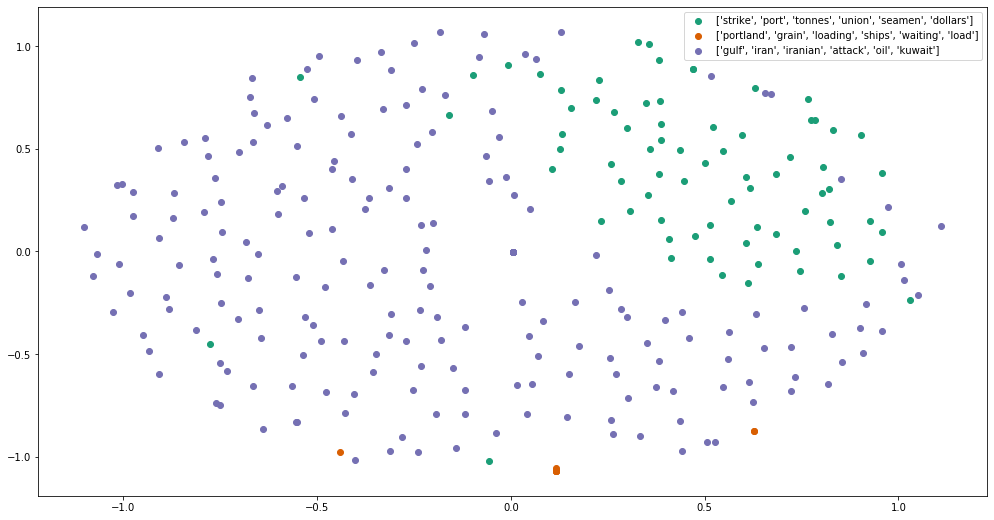

In [88]:
fig, ax = plt.subplots(figsize=(17, 9)) 

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

groups = df_vis.groupby('cluster')

for name, group in groups:
    print(name)
    ax.scatter(group.x, group.y, c  = cluster_colors[name], label = labels[name])
    ax.legend()
    
### everything is far apart! curse of dimensionality 

In [89]:
# kmeans 
# need to research and mess with paramters 
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(m)

clusters = km.labels_.tolist()

Wall time: 1.12 s


In [ ]:
# merge in with original data via pandas
frame = pd.DataFrame(df_retail.index, index = [clusters], columns = ['index_retail'])
frame = pd.merge(frame, df_retail, right_index = True, left_on = 'index_retail')
frame['cluster'] = frame.index.str[0]
frame = frame.reset_index()

In [ ]:
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
order_centroids

In [ ]:
frame.cluster.value_counts() # number of documents per cluster 

## http://brandonrose.org/clustering : more info on finding most common words in cluster, visualizing, hierarchial 
# also try taking average of tf-idf per cluster and using that way. 

In [ ]:
# most common words in clusters 

labels = []
for i in range(3):
    # most common words
    cluster1 = list(frame[frame.cluster == i].index.unique())
    # find documents cluster
    m1 = m[cluster1,:]
    # take mean vector among all documents
    m1 = m1.mean(axis = 0)
    # max values in mean vector 
    lst = []

    for i in np.argsort(np.asarray(m1)[0])[::-1][:3]:
        lst.append(feature_names[i])
        
    labels.append(lst)

In [ ]:
# visualization based on distances: x and y coordinates  

###### should use tsne or umap in reality 

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
df_vis = pd.DataFrame(dict(x = xs, y = ys, cluster = f))

In [ ]:
cluster_labels = dict()
for i in range(len(labels)):
    cluster_labels[i] = labels[i]
    
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

In [ ]:
fig, ax = plt.subplots(figsize=(17, 9)) 

groups = df_vis.groupby('cluster')

for name, group in groups:
    ax.scatter(group.x, group.y, c  = cluster_colors[name], label = cluster_labels[name])
    ax.legend()
    
### everything is far apart!

# SVD

In [411]:
#svd
# try following lingo algorithm as per paper
U, S, Vt = np.linalg.svd(m.todense(), full_matrices = False) # full_matrices make dimensions work. Min(M,N) (why necessary??)
V = Vt.T
#s = np.diag(s)

In [412]:
# ROC in variance based on number of singular values included
true_var = 0
for i in S: 
    true_var += i**2 
    
k_var_lst = []
k_var = 0
for i in S:
    k_var += i**2
    k_var_lst.append(k_var)
    if k_var >= .8*true_var:
        k = np.where(S == i)
        break 

In [413]:
# rate of change of variance
# retain too much if do 80% (140ish topics)
roc = []
for k in range(len(k_var_lst)):
    if k+1 < len(k_var_lst):
        roc.append(abs(k_var_lst[k+1] - k_var_lst[k]) / k_var_lst[k])

In [414]:
# knee in variance ROC 
kn = KneeLocator(range(len(roc)), roc, curve='convex', direction='decreasing')
k = kn.knee
#https://raghavan.usc.edu//papers/kneedle-simplex11.pdf

14


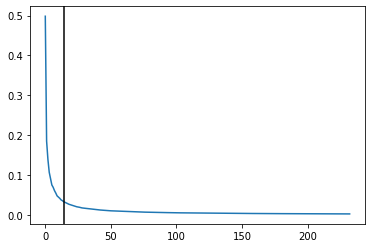

In [416]:
fig, ax = plt.subplots()
ax.plot(roc)
ax.axvline(k, color = 'black')
print(k)

In [417]:
# zero out non-selected k's
S[k:] = 0
V = V[:,:k] 
# V is term to concept. Because no phrases yet, no need to multiple by a term matrix. Currently T = identity 

In [190]:
# cosines of angles between each concept and phrase vector 
#P = np.matmul(V.T, m.toarray())  ## wrong. M should be t x (t+p) term/phrase matrix

In [423]:
# find maximum 3 term vectors for each column (concept) in V
max_w3 = dict()
max_w = []
for r in range(len(V.T)):
    if r in max_w:
        max_w3[r].append(np.array(V.T[r])[0].argsort()[-3:][::-1])
    else:
        max_w3[r] = [np.array(V.T[r])[0].argsort()[-3:][::-1]]
    max_w.append(np.argmax(V.T[r]))
        
    #max_w[r] = []
    #max_w[r].append(np.argmax(V.T[r]))

    
## find maximum 3 or just the maximum? 
# TO DO: overlap between labels
# TO DO: what about phrases? then could just use max 

In [425]:
# find corresponding words -> labels 
labels = dict()
for k,v in max_w3.items():
    labels[k] = []
    for w in v[0]:
        labels[k].append(feature_names[w])

In [428]:
# term-concept label matrix 
# term-term matrix is identity because currently no phrases. 
# base on maximum word, even though displaying top 3 for label 
Q = np.identity(len(feature_names))[:,max_w]

# cij = strength of membership of jth document to ith concept 
C = np.matmul(Q.T, m.T.toarray())

In [429]:
# choose documents for each cluster with strength > .1 
docs = dict()
for r in range(len(C)):
    docs[r] = []
    for c in range(len(C[r])): 
        if C[r][c] > .1: # threshold 
            docs[r].append(c)
            
# documents can be in multiple clusters 
# documents can be in no clusters 


# drop clusters with only 1 document in it 
del_lst = []
for k,v in docs.items():
    if len(v) == 1:
        del_lst.append(k)
for i in del_lst:
    del docs[i]

In [437]:
# create dataframe that indicates which documents belong to which cluster and labels. List of clusters. 
framesvd = df_retail
framesvd['label'] = ''
framesvd['cluster'] = ''
for k,v in docs.items():
    for d in v: 
        framesvd.cluster = np.where(framesvd.index == d, framesvd.cluster + str(k) + ',', framesvd.cluster)
        framesvd.label = np.where(framesvd.index == d, str(labels[k]), framesvd.label)
        
framesvd.cluster = framesvd.cluster.str.split(',')
framesvd.cluster = framesvd.cluster.apply(lambda row: [i for i in row if i != ''])

In [438]:
# percent of documents with no cluster
framesvd['len']= framesvd.cluster.apply(lambda row: len(row))
len(framesvd[framesvd.len == 0]) / len(framesvd)

0.31958762886597936

In [ ]:
# get unique list of topics (categories)
topics = list(df.categories)
topics = [item for sublist in topics for item in sublist]
topics = set(topics)


df[df.categories.map(set(['earn']).issubset)]

df['len'] = df.text.apply(lambda row: len(row))
